#### Notebook setup and imports

In addition to matplotlib and numpy, we will use the `dysts` library for some utilities, and the `degas` library for custom plotting.

    pip install dysts degas



In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Turn on autoreload
%load_ext autoreload
%autoreload 2

from scripts.utils import smape

def smape_rolling(ts1, ts2):
    """Return the smape versus time for two time series."""
    n = min(ts1.shape[0], ts2.shape[0])
    all_smape = list()
    for i in range(n):
        smape_val = smape(ts1[:i], ts2[:i])
        all_smape.append(smape_val)
    return np.array(all_smape)


# Test the chronos model

In [6]:
from scripts.models import ChronosModel

import dysts.flows

equation_name = "Lorenz"
training_length = 1000
# training_length = 512
forecast_length = 100
context_length = 512
model_size = "base"

eq = getattr(dysts.flows, equation_name)()
integrator_args = {
    "pts_per_period": 40,
    "atol": 1e-12,
    "rtol": 1e-12,
}

# traj0 = eq.make_trajectory(1000,
#                             timescale="Lyapunov",
#                             method="Radau", **integrator_args)
# eq.ic = traj0[-1]

traj0 = eq.make_trajectory(training_length + forecast_length,
                            timescale="Lyapunov",
                            method="Radau", **integrator_args)
traj_test = np.array(traj0)[None, :]
traj_train = traj_test[:, :training_length] ## Training data for standard models                                     
traj_test_context = traj_test[:, training_length - context_length:training_length] ## Last context_length points for context models
ic_test = traj_test_context[:, -1] # Last seen point                                                                 
traj_test_forecast = traj_test[:, training_length:] ## Unseen data to be forecast

model = ChronosModel(model=model_size, 
                     context=context_length, 
                     n_samples=5, 
                     prediction_length=forecast_length, 
                     max_chunk=64)

# model = ChronosModel(model=model_size, 
#                      context=context_length, 
#                      n_samples=n_average, 
#                      prediction_length=forecast_length, 
#                      device=device)

for traj in traj_test_context:
    forecast_multivariate = np.array(model.predict(traj.T)).squeeze()


/Users/william/micromamba/envs/chronos/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/william/micromamba/envs/chronos/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


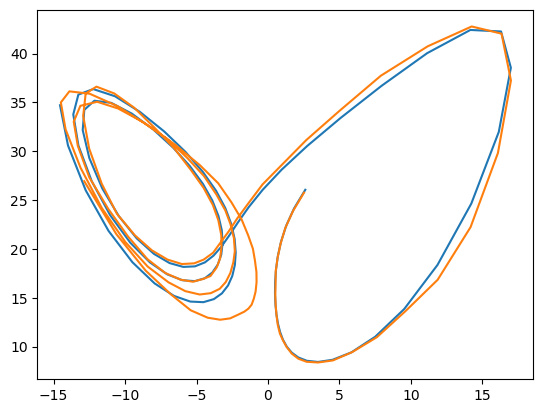

In [3]:

plt.plot(traj_test_forecast.squeeze()[:, 0], traj_test_forecast.squeeze()[:, 2], label="True")
plt.plot(np.mean(forecast_multivariate, axis=1)[0], np.mean(forecast_multivariate, axis=1)[2], label="Forecast")

rolling_smape = smape_rolling(np.mean(forecast_multivariate, axis=1).squeeze().T, traj_test_forecast.squeeze())

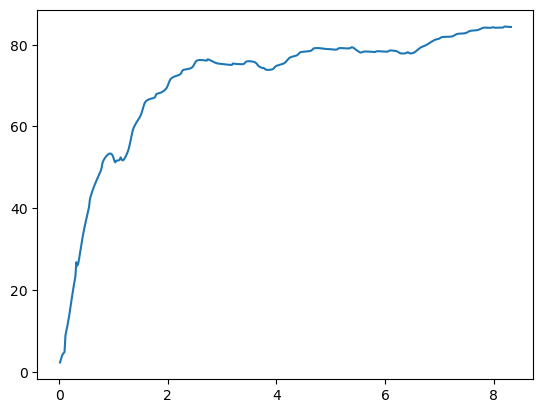

In [237]:
plt.plot(np.arange(len(rolling_smape)) / integrator_args["pts_per_period"], rolling_smape)

In [48]:
import warnings 
import numpy as np

import dysts.flows

## Read system name from the command line
# import argparse
# # Function to process command-line arguments
# def parse_arguments():
#     parser = argparse.ArgumentParser(description='Process a command-line argument.')
#     parser.add_argument('arg1', type=str, help='A string argument')
#     args = parser.parse_args()
#     return args
# args = parse_arguments()
# equation_name = args.arg1
# print(equation_name, flush=True)

equation_name = "Lorenz"
print(equation_name, flush=True)

# num_ic = 20
# training_length = 1000
# context_length = 100
# forecast_length = 64 # Maximum for these models
# n_average = 20

num_ic = 7
training_length = 1000
context_length = 512
forecast_length = 400 # Maximum for these models
n_average = 3
pts_per_period = 40

# dirname = f"chronos_benchmarks_context_{context_length}_granularity_{pts_per_period}"
# ## Check if the directory exists, if not, create it
# import os
# if not os.path.exists(dirname):
#     os.makedirs(dirname)


if training_length > context_length:
    warnings.warn("Training length has been increased to be greater than context length")
    training_length = context_length + 1

## Make a testing set of initial conditions  
eq = getattr(dysts.flows, equation_name)()
integrator_args = {
    "pts_per_period": pts_per_period,
    "atol": 1e-12,
    "rtol": 1e-12,
}
## Pick num_ic random initial conditions
ic_traj = eq.make_trajectory(1000, pts_per_period=10)
np.random.seed(0)
sel_inds = np.random.choice(range(1000), size=num_ic, replace=False).astype(int)
ic_context_test = ic_traj[sel_inds, :]
print("t ", ic_context_test[0], flush=True)
traj_test = list()
for ic in ic_context_test:
    eq.ic = np.copy(ic)
    traj = eq.make_trajectory(training_length + forecast_length,
                              timescale="Lyapunov",
                              method="Radau", **integrator_args)
    traj_test.append(traj)
traj_test = np.array(traj_test)
traj_train = traj_test[:, :training_length] ## Training data for standard models                                     
traj_test_context = traj_test[:, training_length - context_length:training_length]
ic_test = traj_test_context[:, -1] # Last seen point                                                                 
traj_test_forecast = traj_test[:, training_length:]
# save_str_reference = f"forecast_{eq.name}_true_chronos"
# save_str_reference = os.path.join(dirname, save_str_reference)
# np.save(save_str_reference, traj_test_forecast, allow_pickle=True)


import torch
has_gpu = torch.cuda.is_available()
print("has gpu: ", torch.cuda.is_available(), flush=True)
n = torch.cuda.device_count()
print(f"{n} devices found.", flush=True)
if has_gpu:
    device = "cuda"
else:
    device = "cpu"

from scripts.models import ChronosModel

## Run chronos zero-shot benchmark
# for model_size in ["tiny", "mini", "small", "base", "large"]:
for model_size in ["base"]:
    model = ChronosModel(model=model_size, context=context_length, n_samples=n_average, 
                                        prediction_length=forecast_length, device=device)
    print(model_size, flush=True)
    all_traj_forecasts = list()
    ## Loop over the replicate trajectories
    for itr, traj in enumerate(traj_test_context):
        print(itr, flush=True)
        forecast_multivariate = np.array(model.predict(traj.T)).squeeze()
        all_traj_forecasts.append(forecast_multivariate.copy())

    all_traj_forecasts = np.array(all_traj_forecasts)
    all_traj_forecasts = np.moveaxis(all_traj_forecasts, (1, 3, 2), (2, 1, 3))

    # save_str = f"forecast_{eq.name}_{model.name}"
    # save_str = os.path.join(dirname, save_str)
    # np.save(save_str, all_traj_forecasts, allow_pickle=True)




Lorenz


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_92367/2994351492.py:42: UserWarning: Training length has been increased to be greater than context length
  warnings.warn("Training length has been increased to be greater than context length")


t  [ -6.84949155 -10.61056237  18.1736639 ]
has gpu:  False
0 devices found.


/Users/william/micromamba/envs/chronos/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


base
0
7


/Users/william/program_repos/dysts_data/benchmark_results/scripts/models.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context=torch.tensor(current_context),
/Users/william/micromamba/envs/chronos/lib/python3.12/site-packages/chronos/chronos.py:181: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226120/work/aten/src/ATen/native/BucketizationUtils.h:34.)
  torch.bucketize(


In [ ]:
plt.plot(np.arange(len(rolling_smape)) / integrator_args["pts_per_period"], rolling_smape)

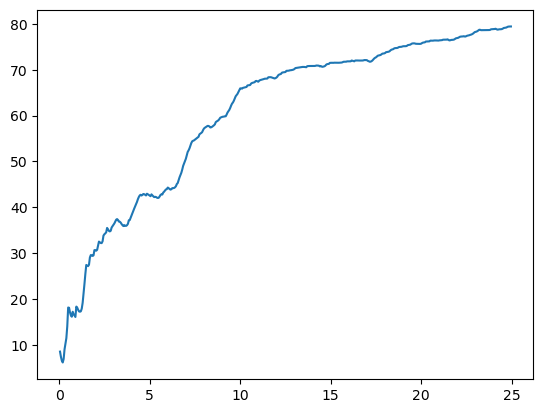

In [234]:
plt.plot(np.arange(len(rolling_smape)) / integrator_args["pts_per_period"], rolling_smape)

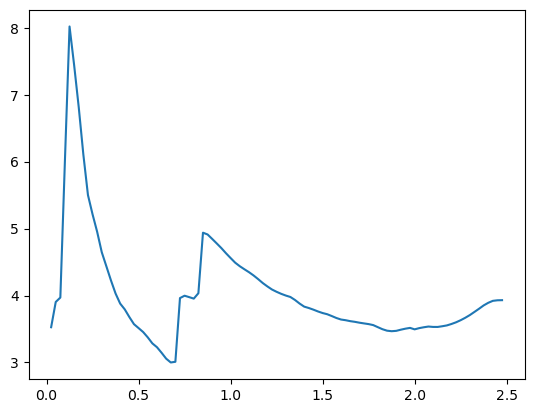

In [213]:
plt.plot(np.arange(len(rolling_smape)) / integrator_args["pts_per_period"], rolling_smape)

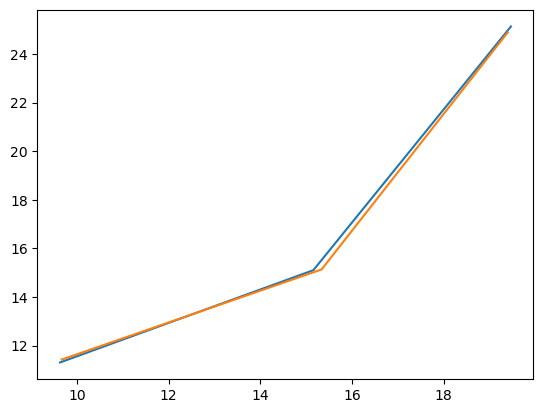

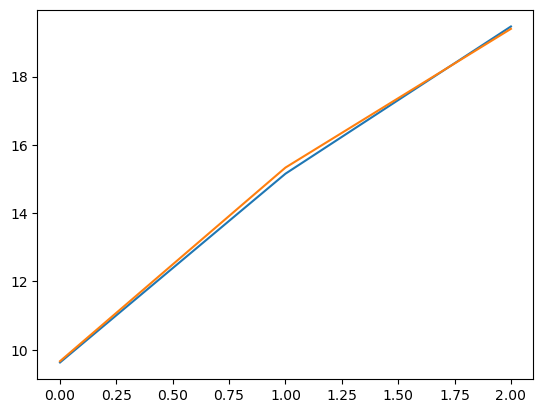

In [162]:
plt.figure()
plt.plot(np.mean(forecast_multivariate, axis=1)[:, 0], np.mean(forecast_multivariate, axis=1)[:, 1])
plt.plot(np.median(forecast_multivariate, axis=1)[:, 0], np.median(forecast_multivariate, axis=1)[:, 1])

plt.figure()
plt.plot(np.mean(forecast_multivariate, axis=1)[:, 0])
plt.plot(np.median(forecast_multivariate, axis=1)[:, 0])

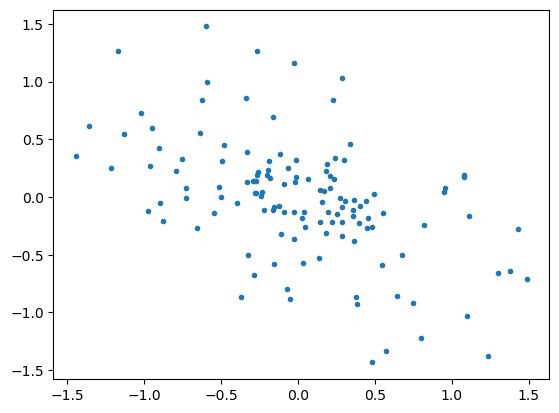

In [104]:
plt.figure()
plt.plot(np.mean(forecast_multivariate, axis=1)[:, 0], traj[model.context:, 0][:128], '.')

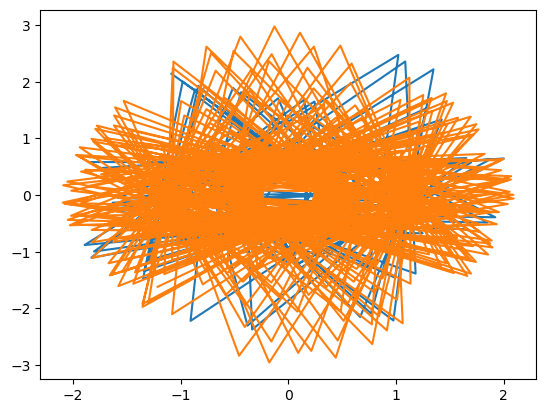

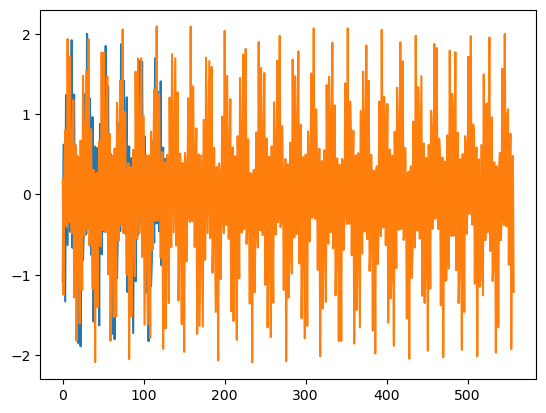

In [111]:
plt.figure()
plt.plot(np.mean(forecast_multivariate, axis=1)[:, 0], np.mean(forecast_multivariate, axis=1)[:, 1])
plt.plot(traj[model.context:, 0], traj[model.context:, 1])

plt.figure()
plt.plot(np.mean(forecast_multivariate, axis=1)[:, 0])
plt.plot(traj[model.context:, 0])

# Plot single system results

In [46]:
from dysts.metrics import smape

equation_name = "Lorenz"
# equation_name = "SprottD"

context = 512

all_scores = dict()
traj_test_forecast = np.load(f"/Users/william/program_repos/dysts_data/benchmark_results/zero-shot/context512/forecast_{equation_name}_true_chronos.npy", allow_pickle=True)
for model_size in ["tiny", "mini", "small", "base"]:
    all_traj_forecasts = np.load(
        f"/Users/william/program_repos/dysts_data/benchmark_results/zero-shot/context512/forecast_{equation_name}_chronos-{model_size}-context{context}.npy", allow_pickle=True
    )
    break
    all_smape_rolling = list()
    for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
        all_smape = list()
        for i in range(traj_pred.shape[1]):
            smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
            # smape_val = smape_rolling(np.nanmean(traj_pred, axis=-1)[:, i], traj_true[:, i])
            all_smape.append(smape_val)
        all_smape_rolling.append(all_smape)
    all_smape_rolling = np.array(all_smape_rolling)
    all_scores[model_size] = np.copy(all_smape_rolling)

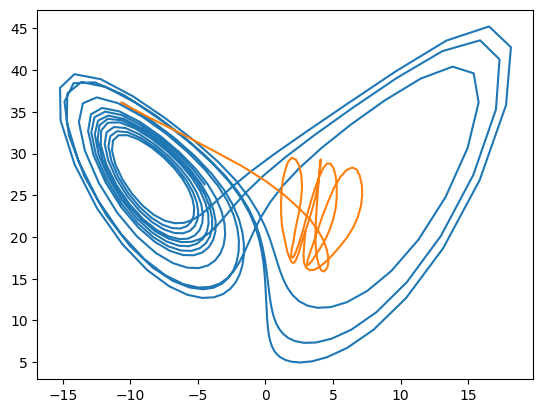

In [47]:
i_traj = 7
traj_test_forecast = traj_test_forecast[i_traj][None, :]
forecast_multivariate = np.moveaxis(all_traj_forecasts[i_traj], (0, 1, 2), (2, 0, 1))[..., :120]
# forecast_multivariate = np.moveaxis(all_traj_forecasts[..., 0], (0, 1, 2), (1, 2, 0))

plt.plot(traj_test_forecast.squeeze()[:, 0], traj_test_forecast.squeeze()[:, 2], label="True")
plt.plot(np.mean(forecast_multivariate, axis=1)[0], np.mean(forecast_multivariate, axis=1)[2], label="Forecast")

# rolling_smape = smape_rolling(np.mean(forecast_multivariate, axis=1).squeeze().T, traj_test_forecast.squeeze())

In [8]:
# for i in range(20):
#     plt.figure()
#     plt.plot(traj_test_forecast[i, :, 0], traj_test_forecast[i, :, 2])
#     # all_forecasts_ave = np.mean(all_traj_forecasts, axis=-1)
#     all_forecasts_ave =  all_traj_forecasts[..., 0]
#     plt.plot(all_forecasts_ave[i, :60, 0], all_forecasts_ave[i, :60, 2], color="k")

# all_forecasts_ave = np.mean(all_traj_forecasts, axis=0)
# plt.plot(all_forecasts_ave[:, 0, 0], all_forecasts_ave[:, 2, 0], color="k")

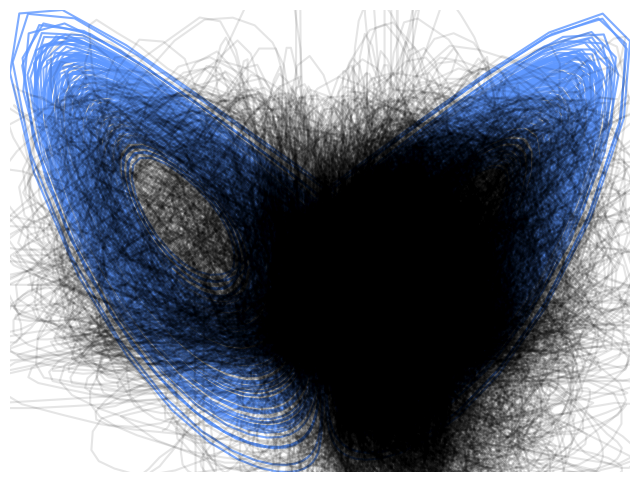

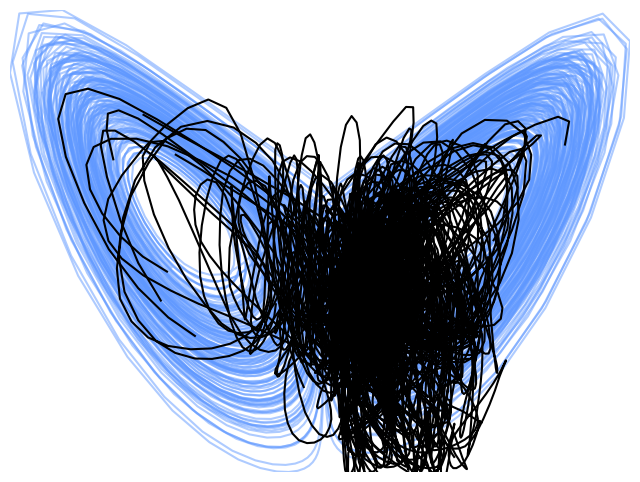

In [9]:
import degas as dg

## Plot all generated trajectories
plt.figure(figsize=(8, 6))
plt.plot(traj_test_forecast[..., 0].T, traj_test_forecast[..., 2].T, color=dg.blue, alpha=0.8)
for traj in all_traj_forecasts:
    plt.plot(traj[:, 0], traj[:, 2], color="k", alpha=0.1)
plt.xlim(np.min(traj_test_forecast[..., 0]), np.max(traj_test_forecast[..., 0]))
plt.ylim(np.min(traj_test_forecast[..., 2]), np.max(traj_test_forecast[..., 2]))
plt.axis('off');

## Plot mean generated trajectories for each initial condition
plt.figure(figsize=(8, 6))
plt.plot(traj_test_forecast[..., 0].T, traj_test_forecast[..., 2].T, color=dg.blue, alpha=0.5);
all_forecasts_ave = np.mean(all_traj_forecasts, axis=-1)
plt.plot(all_forecasts_ave[:, :, 0].T, all_forecasts_ave[:, :, 2].T, "k");
plt.xlim(np.min(traj_test_forecast[..., 0]), np.max(traj_test_forecast[..., 0]))
plt.ylim(np.min(traj_test_forecast[..., 2]), np.max(traj_test_forecast[..., 2]))
plt.axis('off');


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_91366/66930209.py:6: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)


Text(0.5, 1.0, 'SMAPE for Lorenz forecast with tiny model')

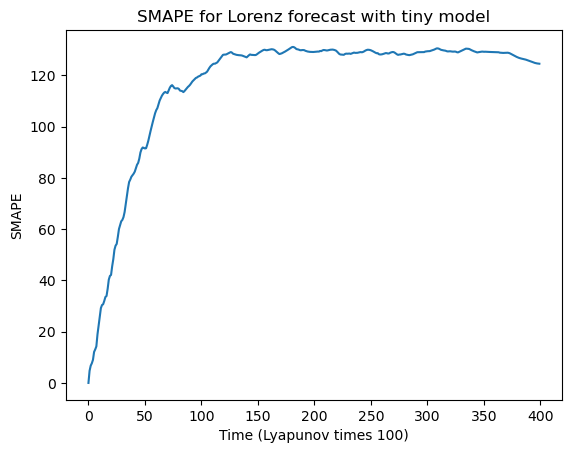

In [10]:
all_smape_rolling = list()

for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
    all_smape = list()
    for i in range(traj_pred.shape[1]):
        smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
        # smape_val = smape_rolling(np.nanmean(traj_pred, axis=-1)[:, i], traj_true[:, i])
        if np.all(np.isnan(smape_val)):
            pass
        else:
            smape_val[np.isnan(smape_val)] = 0
        all_smape.append(smape_val)
    all_smape_rolling.append(all_smape)
all_smape_rolling = np.array(all_smape_rolling)

plt.plot(np.nanmedian(all_smape_rolling, axis=(0, 1)))
plt.xlabel("Time (Lyapunov times 100)")
plt.ylabel("SMAPE")
plt.title(f"SMAPE for {equation_name} forecast with {model_size} model")

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_91366/66930209.py:6: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)


Text(0.5, 1.0, 'SMAPE for Lorenz forecast with base model')

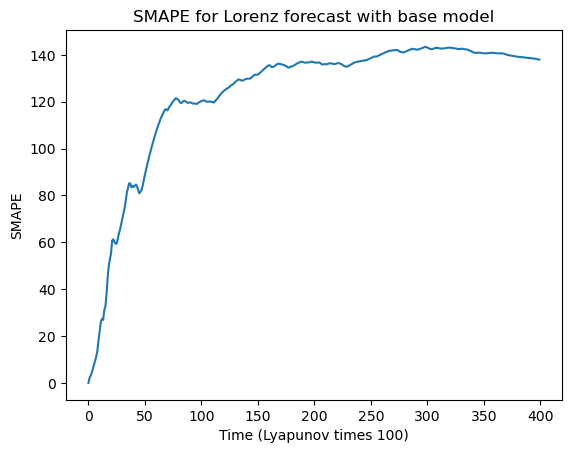

# Properties across many models

#### First, let's load all of the zero-shot forecasting results. This will take a few minutes

In [39]:
from dysts.base import get_attractor_list

model_sizes = ["tiny", "mini", "small", "base", "large"]
all_traces  = dict()

equation_names = get_attractor_list()
for equation_name in equation_names:
    
    all_traces[equation_name] = dict()
    for model_size in model_sizes:
        try:
            traj_test_forecast = np.load(f"./zero-shot/forecast_{equation_name}_true_chronos.npy", allow_pickle=True)
            all_traj_forecasts = np.load(
                f"./zero-shot/forecast_{equation_name}_chronos-{model_size}-context100.npy", allow_pickle=True
            )
        except:
            print(f"Skipping {equation_name} {model_size}", flush=True)
            all_traces.pop(equation_name, None)
            continue
        
        # print(equation_name, flush=True)

        all_smape_rolling = list()
        for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
            all_smape = list()
            for i in range(traj_pred.shape[1]):
                smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
                if np.all(np.isnan(smape_val)):
                    pass
                else:
                    smape_val[np.isnan(smape_val)] = 0
                all_smape.append(smape_val)
            all_smape_rolling.append(all_smape)
        all_smape_rolling = np.array(all_smape_rolling)

        all_traces[equation_name][model_size] = np.nanmedian(np.nanmean(np.copy(all_smape_rolling), axis=1), axis=0)


/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_59255/3520930605.py:27: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)


Skipping ArnoldWeb tiny
Skipping ArnoldWeb mini
Skipping ArnoldWeb small
Skipping ArnoldWeb base
Skipping ArnoldWeb large
Skipping BlinkingRotlet tiny
Skipping BlinkingRotlet mini
Skipping BlinkingRotlet small
Skipping BlinkingRotlet base
Skipping BlinkingRotlet large
Skipping Bouali tiny
Skipping Bouali mini
Skipping Bouali small
Skipping Bouali base
Skipping Bouali large
Skipping BurkeShaw tiny
Skipping BurkeShaw mini
Skipping BurkeShaw small
Skipping BurkeShaw base
Skipping BurkeShaw large
Skipping CaTwoPlus tiny
Skipping CaTwoPlus mini
Skipping CaTwoPlus small
Skipping CaTwoPlus base
Skipping CaTwoPlus large
Skipping CaTwoPlusQuasiperiodic tiny
Skipping CaTwoPlusQuasiperiodic mini
Skipping CaTwoPlusQuasiperiodic small
Skipping CaTwoPlusQuasiperiodic base
Skipping CaTwoPlusQuasiperiodic large
Skipping CellCycle tiny
Skipping CellCycle mini
Skipping CellCycle small
Skipping CellCycle base
Skipping CellCycle large
Skipping ChenLee tiny
Skipping ChenLee mini
Skipping ChenLee small
Skip

#### Plot forecast results averaged across models

In [78]:
ts0 = np.random.normal(size=64)
ts1 = ts0 + 1e-2 * np.random.normal(size=64)

smape(ts0, ts1)

# plt.plot(smape_rolling(ts0, ts1))

2.5086596686149

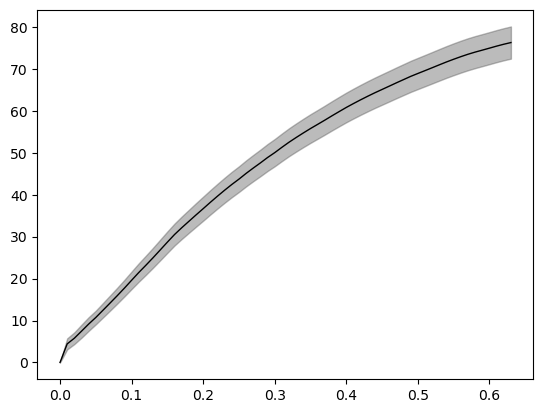

In [47]:
import degas as dg



In [46]:
n_sys = all_all_vals.shape[1]

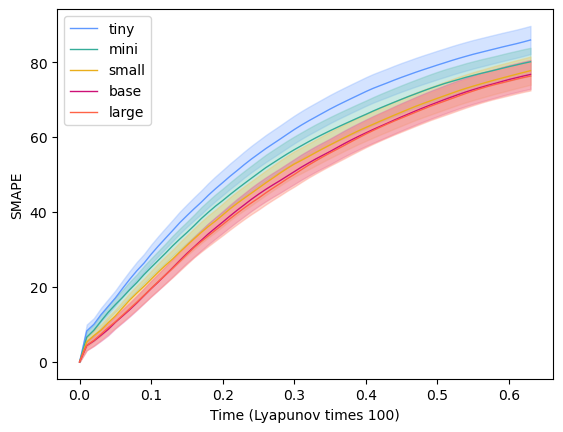

In [54]:

all_all_vals = list()

for model_size in all_traces["Lorenz"].keys():
    all_vals = list()
    for equation_name in all_traces.keys():
        vals = all_traces[equation_name][model_size]
        all_vals.append(vals)
    all_all_vals.append(np.array(all_vals))
all_all_vals = np.array(all_all_vals)

all_colors = [dg.blue, dg.turquoise, dg.orange, dg.magenta, dg.red]

# import degas as dg
for i, model_size in enumerate(model_sizes):
    n_sys = all_all_vals.shape[1]
    mv_vals = np.mean(all_all_vals, axis=1)[i]
    std_vals = np.std(all_all_vals, axis=1)[i]

    # plt.plot(mv_vals, label=model_size)
    # plt.semilogx()
    dg.plot_err(mv_vals, std_vals / np.sqrt(n_sys), x=np.arange(0, len(mv_vals))/100, color=all_colors[i], label=model_size)

    plt.xlabel("Time (Lyapunov times)")
    plt.ylabel("SMAPE")
plt.legend()


### Correlation between forecast and invariant properties of different dynamical systems

In [86]:

## Load the invariant properties for each individual system
import dysts.flows as dfl
all_lyap = list()
all_corrdim = list()
all_acc = list()
for equation_name in all_traces:
    all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)

    # spec = np.array(getattr(dfl, equation_name)().lyapunov_spectrum_estimated)
    # try:
    #     all_lyap.append(np.sum(spec[spec > 0]))
    # except:
    #     all_lyap.append(getattr(dfl, equation_name)().maximum_lyapunov_estimated)
    all_corrdim.append(getattr(dfl, equation_name)().correlation_dimension)
    all_acc.append(all_traces[equation_name]["mini"][6])

Text(0, 0.5, 'Correlation with Lyapunov Exponent')

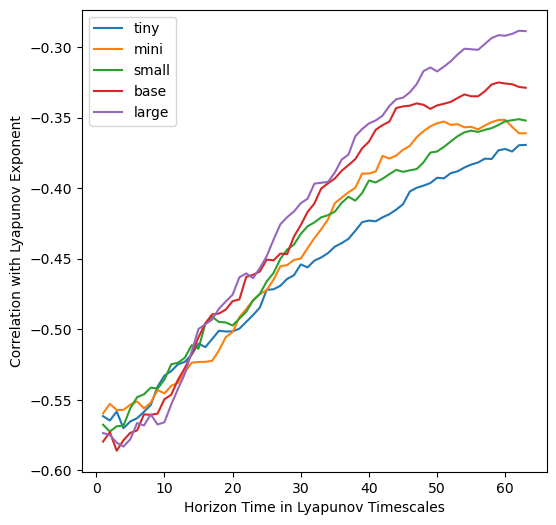

In [90]:
from scipy.stats import spearmanr

## Load the invariant properties for each individual system
plt.figure(figsize=(6, 6))
for model_size in model_sizes:
    all_corr_lyap = list()
    all_corr_corrdim = list()
    nt = len(all_traces[equation_name][model_size])
    for i in range(nt):
        all_acc = list()
        for equation_name in all_traces:
            all_acc.append(all_traces[equation_name][model_size][i])
        corr = spearmanr(all_lyap, all_acc).correlation
        all_corr_lyap.append(corr)
        corr = spearmanr(all_corrdim, all_acc).correlation
        all_corr_corrdim.append(corr)
    plt.plot(all_corr_lyap, label=model_size)
plt.legend()
plt.xlabel("Horizon Time in Lyapunov Timescales")
plt.ylabel("Correlation with Lyapunov Exponent")

# plt.plot(all_corr_corrdim)

# In-context learning experiments

+ Titrate the number of forecasts, see how predictions improve
+ Collect 50-100 samples from attractor, but don't reset the model between them

In [20]:
from dysts.metrics import smape

equation_name = "Lorenz"
# equation_name = "SprottD"

all_scores = dict()
traj_test_forecast = np.load(f"/Users/william/program_repos/dysts_data/benchmark_results/icl/incontext_Lorenz_true.npy", allow_pickle=True)
for model_size in ["tiny", "mini"]:
    all_traj_forecasts = np.load(
        f"/Users/william/program_repos/dysts_data/benchmark_results/icl/incontext_Lorenz_chronos-{model_size}-context100.npy", allow_pickle=True
    )[1]
    all_traj_forecasts = np.moveaxis(all_traj_forecasts, (1,2,3), (2,3,1))
    all_smape_rolling = list()
    for traj_pred, traj_true in zip(all_traj_forecasts, traj_test_forecast):
        all_smape = list()
        for i in range(traj_pred.shape[1]):
            smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)
            # smape_val = smape_rolling(np.nanmean(traj_pred, axis=-1)[:, i], traj_true[:, i])
            all_smape.append(smape_val)
        all_smape_rolling.append(all_smape)
    all_smape_rolling = np.array(all_smape_rolling)
    all_scores[model_size] = np.copy(all_smape_rolling)

/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/william/micromamba/envs/dysts_benchmarks/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_16833/2672040046.py:17: RuntimeWarning: All-NaN slice encountered
  smape_val = np.nanmedian(np.array([smape_rolling(item[i], traj_true[:, i]) for item in traj_pred.T]), axis=0)


In [23]:
q1 = np.nanmean(all_scores[model_size], axis=(1, 2))

In [24]:
q2 = np.nanmean(all_scores[model_size], axis=(1, 2))

In [27]:
np.allclose(q1, q2)

True

In [14]:
print(traj_test_forecast.shape)
print(np.moveaxis(all_traj_forecasts, (1,2,3), (2,3,1)).shape)

(100, 64, 3)
(100, 64, 3, 20)


In [7]:
all_traj_forecasts.shape

(100, 3, 20, 64)

In [10]:
print(traj_test_forecast.shape)
print(all_traj_forecasts.shape)

(20, 64, 3)
(20, 64, 3, 20)
